In [1]:
%matplotlib inline
import numpy as np
import sys
import matplotlib.pyplot as plt
import os
from scipy import fftpack, stats
from lmfit.models import GaussianModel


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#os.chdir('C:\\Users\\zhil\\Documents\\ZQ_Programs\\Coding')
if (sys.platform != 'linux'):
    os.chdir('C:\\Users\\zhil\\Documents\\Coding')
os.getcwd()

'/home/digitalpig/Coding/GPC_Fit'

In [3]:
#dat = np.loadtxt(open("ZHIL1669.arw","rb"),delimiter="\t",skiprows=1)
# Empower ARW file does not follow the line end convention in either Linux or Windows way, need to convert

infile = 'ZHIL1669.arw'
#outfile = infile + '-fixed'
#with open(infile, 'rb') as f, open(outfile, 'wb') as g:
#    content = f.read()
#    g.write(content.replace(b'\r', b'\r\n'))
#os.rename(outfile, infile)

dat = np.loadtxt(open(infile,"rb"),delimiter="\t",skiprows=1)
x = dat[:, 0]
y = dat[:, 1]

the R-sqaure of baseline fitting is: -0.9999


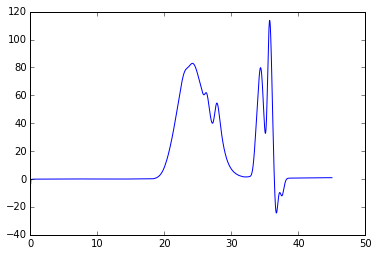

In [4]:
# I need to do the linear regression first to get rid of baseline drifting.
bl_start = 1.
bl_end = 15.

ibl_start = np.where(x==bl_start)[0]
ibl_end = np.where(x==bl_end)[0]
slope, intercept, r_value, p_value, std_err = stats.linregress(x[ibl_start:ibl_end],y[ibl_start:ibl_end])
print('the R-sqaure of baseline fitting is: {0:.4}'.format(r_value))
y_drifting = slope * x + intercept
y = (y - y_drifting)
plt.plot(x,y)


In [5]:

# Get the code from https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way


# The problem now is how to find the initial parameters for peak fit.
y1 = np.diff(y, 1)
y1_fft = fftpack.rfft(y1)
y1_freq = fftpack.rfftfreq(len(y1),x[3]-x[2])

spectrum = y1_fft **2
cutoff_idx = spectrum < (spectrum.max()/5)
y1_fft_filtered = y1_fft.copy()
y1_fft_filtered[cutoff_idx] = 0
y1_filtered = fftpack.irfft(y1_fft_filtered)



y2 = np.diff(y, 2)
y2_fft = fftpack.rfft(y2)
y2_freq = fftpack.rfftfreq(len(y2),x[3]-x[2])

spectrum = y2_fft **2
cutoff_idx = spectrum < (spectrum.max()/5)
y2_fft_filtered = y2_fft.copy()
y2_fft_filtered[cutoff_idx] = 0
y2_filtered = fftpack.irfft(y2_fft_filtered)



# The next step is to find out the zero points for 1st and 2nd degree of differentiation...
start = 17. # later would be a user-input term for the start of peak recognization
end = 32.   # later would be a user-input term for the end of peak recognization
x_start = np.where(x==start)[0]
x_end = np.where(x==end)[0]
peak_location = []
peak_inflection_left = []
peak_inflection_right = []
amp = []
amp_threshold = 20
del_loc = []
previous = start
for i in range(x_start,x_end-1):
    if (y1[i]*y1[i+1] < sys.float_info.epsilon):  # Found that it is better not to smooth
        if (x[i]-previous > 1.) and (y[i] > amp_threshold):
            peak_location.append(x[i])
            amp.append(y[i])
            previous = x[i]
        continue
    if (y2_filtered[i-1]*y2_filtered[i] < sys.float_info.epsilon):
        if (y2_filtered[i-1] > sys.float_info.epsilon):
            peak_inflection_left.append(x[i+2])
        else:
            peak_inflection_right.append(x[i+2])
# Then, I need to clean the peak location data


print('peak locations are: {0}'.format(peak_location))
print('peak left inflections are: {0}'.format(peak_inflection_left))
print('peak right inflections are: {0}'.format(peak_inflection_right))
print('peak amplitudes are: {0}'.format(amp))
peaks = []




peak locations are: [24.183330000000002, 25.883330000000001, 27.16667]
peak left inflections are: [18.233329999999999, 19.83333, 21.600000000000001, 22.966670000000001, 23.850000000000001, 25.08333, 26.08333, 27.449999999999999, 28.800000000000001, 30.066669999999998, 30.866669999999999]
peak right inflections are: [19.016670000000001, 20.733329999999999, 22.350000000000001, 23.216670000000001, 24.533329999999999, 25.483329999999999, 26.766670000000001, 28.133330000000001, 29.449999999999999, 30.616669999999999, 31.383330000000001]
peak amplitudes are: [82.906165619884092, 60.383919152870675, 39.964311549119486]


num is 1
num is 2
num is 3
name is g1_
name is g2_
name is g3_


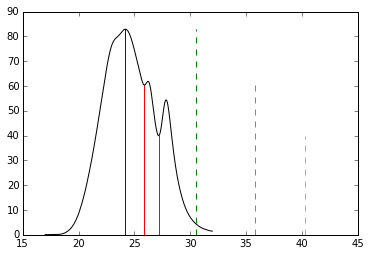

[{'g1_': 1, 'g1_amplitude': 82.906165619884092, 'g1_center': 24.183330000000002, 'g1_sigma': 6.3000000000000007}, {'g2_': 2, 'g2_center': 25.883330000000001, 'g2_amplitude': 60.383919152870675, 'g2_sigma': 9.9000000000000021}, {'g3_': 3, 'g3_amplitude': 39.964311549119486, 'g3_sigma': 13.150000000000002, 'g3_center': 27.16667}]


In [6]:
# Iterate for a peak location/width/amplitude
def add_peak_info(p_loc, p_amp, p_left, p_right, p_num):
    '''
    This is the function to add the peak information to the p_list dictionary object
    Usage:
    peak = add_peak_info(p_loc, p_amp, p_left, p_right, index, p_num)
    '''
    peak_name = 'g' + str(p_num) + '_'
    peak_location = peak_name + 'center'
    peak_width = peak_name + 'sigma'
    peak_amp = peak_name + 'amplitude'
    peak = dict(zip([peak_name,peak_location,peak_width,peak_amp],[p_num,p_loc,p_right-p_left,p_amp]))
    return peak


num = 0

#TODO: Here is the last break should let the circle go to the next i circle (looking for next left inflection)
try:
    for i in range(len(peak_inflection_left)):
        left = peak_inflection_left[i]
        for j in range(len(peak_inflection_right)):
            if (peak_inflection_right[j] > left):
                right = peak_inflection_right[j]
                for k in range(len(peak_location)):
                    if ((left <= peak_location[k]) and (peak_location[k] <= right)):
                        num += 1
                        print('num is {0}'.format(num))
                        peaks.append(add_peak_info(peak_location[k],amp[k],left,right,num)) # call the function to add peak info to the dictionary
                        peak_location.pop(k)
                        amp.pop(k)
                        peak_inflection_left.pop(i)
                        peak_inflection_right.pop(j)
                        break
                peak_inflection_right.pop(j)
        peak_inflection_right.pop(j)
    peak_inflection_left.pop(i)
except IndexError:
    pass
                    

for i in range(1, num+1):
    name = 'g' + str(i) + '_'
    x2 = peaks[i-1][name+'center']
    y2 = peaks[i-1][name+'amplitude']
    displace = peaks[i-1][name+'sigma']
    print('name is {0}'.format(name))
    plt.plot((x2,x2),(0,y2),'-')
#    plt.plot((x2-displace,x2-displace),(0,y2),'--')
    plt.plot((x2+displace,x2+displace),(0,y2),'--')

plt.plot(x[x_start:x_end],y[x_start:x_end])
plt.show()

print(peaks) 
   


[[Model]]
    ((Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_'))
[[Fit Statistics]]
    # function evals   = 291
    # data points      = 900
    # variables        = 9
    chi-square         = 6868.485
    reduced chi-square = 7.709
[[Variables]]
    g1_center:      26         +/- 0.121447 (0.47%) (init= 24)
    g1_sigma:       2.87338149 +/- 0.146638 (5.10%) (init= 3)
    g1_amplitude:   119.302265 +/- 49.20338 (41.24%) (init= 82)
    g1_fwhm:        6.76629621 +/- 0.345306 (5.10%)  == '2.3548200*g1_sigma'
    g2_center:      24         +/- 0.021476 (0.09%) (init= 26)
    g2_amplitude:   360.104407 +/- 48.18927 (13.38%) (init= 60)
    g2_sigma:       2.02008833 +/- 0.057934 (2.87%) (init= 3)
    g2_fwhm:        4.75694440 +/- 0.136424 (2.87%)  == '2.3548200*g2_sigma'
    g3_center:      28.0235651 +/- 0.010703 (0.04%) (init= 27)
    g3_sigma:       0.52723132 +/- 0.015819 (3.00%) (init= 0.5)
    g3_amplitude:   36.8603143 +/- 1.746909 (4

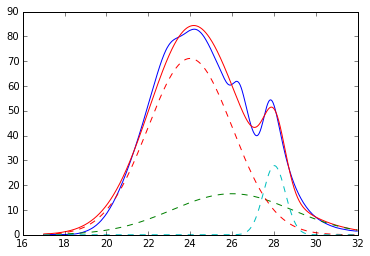

{'g2_center': 24.000000000611653, 'g2_sigma': 2.0200883312273743, 'g3_amplitude': 36.860314384460324, 'g1_sigma': 2.8733814969234102, 'g1_amplitude': 119.30226517816963, 'g3_center': 28.023565165832032, 'g1_center': 25.999999999999964, 'g2_amplitude': 360.1044077803619, 'g3_sigma': 0.5272313210902736}


In [7]:
gauss1  = GaussianModel(prefix='g1_')
pars = gauss1.make_params()

pars['g1_center'].set(24, min=22, max=26)
pars['g1_sigma'].set(3, min=1)
pars['g1_amplitude'].set(82, min=10)

gauss2  = GaussianModel(prefix='g2_')

pars.update(gauss2.make_params())

pars['g2_center'].set(26, min=24, max=28)
pars['g2_sigma'].set(3, min=1)
pars['g2_amplitude'].set(60, min=20)

gauss3  = GaussianModel(prefix='g3_')

pars.update(gauss3.make_params())
pars['g3_center'].set(27, min=25, max=29)
pars['g3_sigma'].set(0.5, min=0.1)
pars['g3_amplitude'].set(40, min=20)
mod = gauss1 + gauss2 + gauss3



#out = mod.fit(y, pars, x=x)
out = mod.fit(y[x_start:x_end], pars, x=x[x_start:x_end])
print(out.fit_report(min_correl=0.5))

comps = out.eval_components(x=x[x_start:x_end])

plt.plot(x[x_start:x_end],y[x_start:x_end])
plt.plot(x[x_start:x_end], out.best_fit, 'r-')
plt.plot(x[x_start:x_end],comps['g1_'],'--',x[x_start:x_end],comps['g2_'],'--',x[x_start:x_end],comps['g3_'],'--')
plt.show()
print(out.best_values)